In [57]:
import pandas as pd
import gzip
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, plot_confusion_matrix, auc, plot_roc_curve

# Load the Amazon review dataset


In [58]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')


In [59]:
df = getDF('app_reviews.gz')

In [60]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1N4O8VOJZTDVB,B004A9SDD8,Annette Yancey,"[1, 1]","Loves the song, so he really couldn't wait to ...",3.0,Really cute,1383350400,"11 2, 2013"
1,A2HQWU6HUKIEC7,B004A9SDD8,"Audiobook lover ""Kathy""","[0, 0]","Oh, how my little grandson loves this app. He'...",5.0,2-year-old loves it,1323043200,"12 5, 2011"
2,A1SXASF6GYG96I,B004A9SDD8,Barbara Gibbs,"[0, 0]",I found this at a perfect time since my daught...,5.0,Fun game,1337558400,"05 21, 2012"
3,A2B54P9ZDYH167,B004A9SDD8,"Brooke Greenstreet ""Babylove""","[3, 4]",My 1 year old goes back to this game over and ...,5.0,We love our Monkeys!,1354752000,"12 6, 2012"
4,AFOFZDTX5UC6D,B004A9SDD8,C. Galindo,"[1, 1]",There are three different versions of the song...,5.0,This is my granddaughters favorite app on my K...,1391212800,"02 1, 2014"


# Filter only the columns we need - review and rating

In [61]:
df = df[['reviewText', 'overall']]
df

,reviewText,overall
0,"Loves the song, so he really couldn't wait to ...",3.0
1,"Oh, how my little grandson loves this app. He'...",5.0
2,I found this at a perfect time since my daught...,5.0
3,My 1 year old goes back to this game over and ...,5.0
4,There are three different versions of the song...,5.0
...,...,...
752932,I love it!!!!!!!!!! really keeps your attenti...,5.0
752933,Okay but there are so many free ones that are ...,3.0
752934,Another great jewels game that just keeps you ...,4.0
752935,I find this the best jewels star ever. There s...,5.0


# Ensure the datatype of rating is int

In [62]:
df['overall'] = df['overall'].astype('int32')
df.dtypes

reviewText    object
overall        int32
dtype: object

# Consider 3 stars and above as a positive review

In [63]:
df['reviewText'] = df['reviewText'].str.lower()
df['overall'].replace([5, 4, 3, 2, 1], [2, 2, 2, 0, 0], inplace=True)
df

,reviewText,overall
0,"loves the song, so he really couldn't wait to ...",2
1,"oh, how my little grandson loves this app. he'...",2
2,i found this at a perfect time since my daught...,2
3,my 1 year old goes back to this game over and ...,2
4,there are three different versions of the song...,2
...,...,...
752932,i love it!!!!!!!!!! really keeps your attenti...,2
752933,okay but there are so many free ones that are ...,2
752934,another great jewels game that just keeps you ...,2
752935,i find this the best jewels star ever. there s...,2


# Class imbalance and sample size too large to be computed later on, needs reduction

In [64]:
df['overall'].value_counts()

2    629839
0    123098
Name: overall, dtype: int64

# Randomly drop fractions of each class so that the total sample size is reduced and classes become balanced

In [65]:
# shuffle
df = df.sample(frac=1).reset_index(drop=True)

df_narrowed = df.drop(df.query('overall == 2').sample(frac=.96).index)
df_narrowed = df_narrowed.drop(df_narrowed.query('overall == 0').sample(frac=.8).index)
df_narrowed

,reviewText,overall
49,this is a fun game and i highly recommend it! ...,2
53,i have played bubble buster so much i just did...,0
74,most of this creatures games are lame but i l...,2
84,this one you have to drive like on a race trac...,2
88,i don't understand some of the things on the g...,2
...,...,...
752868,"but this game is really bad.first, its kind of...",0
752885,"it opened with no problem, but once you go to ...",0
752894,"no other words are necessary, excellent, excel...",2
752914,at this time they are missing one of the major...,0


# Classes are now similar in size

In [66]:
df_narrowed['overall'].value_counts()

2    25194
0    24620
Name: overall, dtype: int64

# Remove stopwords and punctuations

In [67]:
sw = stopwords.words('english')
df_narrowed['reviewText'] = df_narrowed['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))
df_narrowed['reviewText'] = df_narrowed['reviewText'].str.replace('[^\w\s]','')
df_narrowed

,reviewText,overall
49,fun game highly recommend it lots bonus games ...,2
53,played bubble buster much give pro good chance...,0
74,creatures games lame like one 10 times better ...,2
84,one drive like race track im good steering it,2
88,understand things game keep playing like graph...,2
...,...,...
752868,game really badfirst kind sneaky getting pay r...,0
752885,opened problem go pick photo gallery stops res...,0
752894,words necessary excellent excellent excellent ...,2
752914,time missing one major satellite tv providers ...,0


In [68]:
x = df_narrowed['reviewText']
y = df_narrowed['overall']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, stratify=y, random_state=0, shuffle=True)

# Time consuming, but in other scenarios, consider using gridsearch for evaluating different gram levels for NLP so that we can choose the best parameter

In [54]:
# param_grid = [
#     {'vect__ngram_range': [(1,1), (1,2), (1,3), (1,4), (2,2), (2,3), (2,4)],
#     'vect__min_df': [0.005, 0.0005, 0.00005],
#      'clf__penalty': ['l1', 'l2', 'elasticnet', 'none'],
#      'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
# ]

# pipeline = Pipeline([('vect' , TfidfVectorizer()), ('clf', LogisticRegression())])
# gs = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
# gs.fit(x, y)
# best_parameters = gs.best_params_
# best_parameters

# Transform to TFIDF and fit Logistic Regression on the dataset

In [45]:
vectorizer = TfidfVectorizer(ngram_range=(1,1))
clf = LogisticRegression()

x_train = vectorizer.fit_transform(x_train).toarray()
x_test = vectorizer.transform(x_test).toarray()

In [18]:
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)

# Save the model for twitter sentiment analysis

In [23]:
pickle.dump(vectorizer, open('model/vectorizer.pickle', 'wb'))
pickle.dump(clf, open('model/classifier.pickle', 'wb'))

In [69]:
clf = pickle.load(open('model/classifier.pickle', 'rb'))
vectorizer = pickle.load(open('model/vectorizer.pickle', 'rb'))

In [72]:
accuracy = accuracy_score(y_test, predictions)
print('Accuracy score = {}'.format(accuracy))

Accuracy score = 0.8478369968884873


# Confusion Matrix

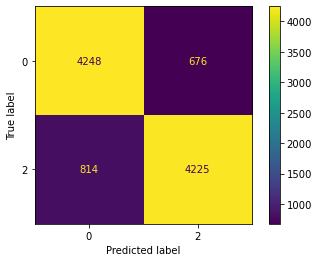

In [74]:
plot_confusion_matrix(clf, x_test, y_test)

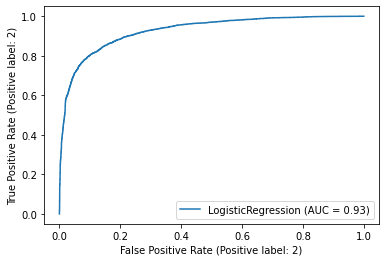

In [75]:
predictions = clf.predict(x_test)

plot_roc_curve(clf, x_test, y_test) 